In [1]:
'''
主要是对上一步的评分做进一步的修正，添加一些新的特征，比如主题特征；word2vec等
'''

In [2]:
import os
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import re, collections
from collections import defaultdict
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn import ensemble
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score

# 读取数据

In [3]:
essay_csv = "essay_test.csv"
# 读取数据
#dataframe = pd.read_csv('essays_and_scores.csv', encoding = 'latin-1')

dataframe = pd.read_csv(essay_csv, encoding = 'latin-1')
#copy一份数据
data = dataframe[['id','essay','score']].copy()

## 探索数据

In [4]:
pd.DataFrame(data)

id                                              essay  score
0     10001  Dear Jerry. I've heard about that you will giv...   19.5
1     10002  Dear Jerry I'm glad that you'll respresent you...   16.5
2     10003  Dear Jerry, I am very happy to hear that you w...   20.5
3     10004  Dear Je I'm so happy to hear that you will hav...   15.5
4     10005  Dear Jerry, I am so glad to hear that you will...   19.0
...     ...                                                ...    ...
996   11045  Dear Jerry, First, you must know how and what ...   17.5
997   11046                          Dear Jerry, Yours, Li Hua    0.0
998   11047                          Dear Jerry, Yours, Li Hua    0.0
999   11048                          Dear Jerry, Yours, Li Hua    0.0
1000  11049                          Dear Jerry, Yours, Li Hua    0.0

[1001 rows x 3 columns]

In [5]:
#把score列转换为列表
scores = data["score"]
scores = [*scores]
scores
type(scores)

list

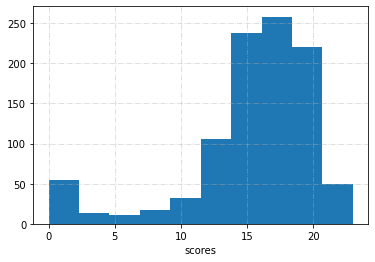

count    1001.000000
mean       15.324176
std         4.992700
min         0.000000
25%        14.000000
50%        16.500000
75%        18.500000
max        23.000000
Name: score, dtype: float64

In [6]:
# 绘制分数分布图& describe数据信息
plt.figure() #初始化一张图
x = scores
plt.hist(x)  #直方图关键操作
plt.grid(alpha=0.5,linestyle='-.') #网格线，更好看 
plt.xlabel('scores')  
plt.show()
data["score"].describe()

**基本信息：共有1001份答卷，分数多分布在15-20之间，平均分为15分

<AxesSubplot:>

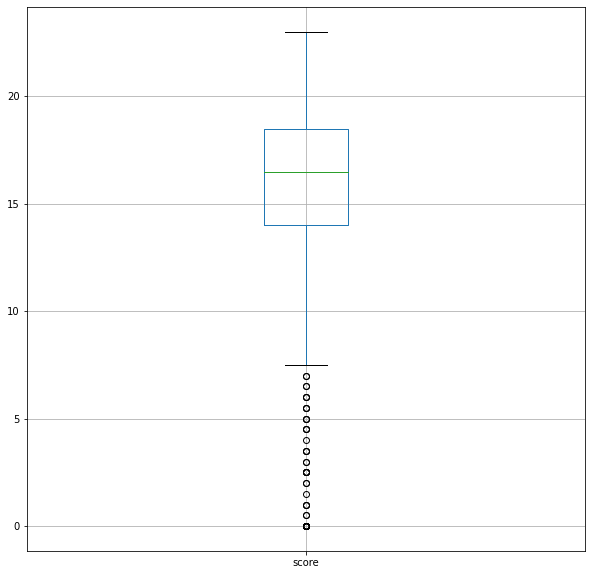

In [7]:
## 继续探索，绘制箱线图

%matplotlib inline
# 横坐标为分数，纵坐标为箱线图 也就是分数分布
data.boxplot(column = 'score', figsize = (10, 10))

In [8]:
# 统计单词数
data["word_count"] = data['essay'].str.strip().str.split().str.len()

In [9]:
# 绘制单词数目的频数直方图
data.hist(column='word_count',bins=25, sharey=True, sharex=True,figsize=(7,4)) 
plt.suptitle('Word count#')
plt.xlabel('Number of words')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

** 可以看出，大部分的篇章的单词数都集中在100-150之间

In [10]:
import seaborn as sns
## 探索单词数与得分之间的关系
topic_number = 0
# 绘制画布
plt.figure(figsize=(15, 10))
sns.violinplot(x='score', y='word_count', data=data)
plt.suptitle('Word count by score')
#plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


+ 可以看出，基本随着单词数的增加，分数也上升，但是到了某个分数段，就与单词数无关了

# 数据预处理

因为有些单词可能会出现拼写错误，这都会影响之后的语言学统计，因此我们把单词首先做一个修改，然后再做语言学统计

In [10]:
# textblob测试 ----纠正效果不好，就先算了
text = "Dear Jerry I am so gold to know that you will make a speech for senior high school students. This is a good chance for you to show yourself. Before you make this English speech, there are something you should know. The topic and the content of the speech are the most important parts. They will help you attract those students to listen carefully. Besides you also should pay attention to you body langurage.It will make your speech more exciting. The final part is making your leave politely. After you finish your speech, it's important to leave politely. It will make people more comfortable. Hope my suggestions will work. and I trust you will make a wonderfur speech. I am looking forward to your success. Yours, Li Hua"

In [11]:
from textblob import TextBlob
text = TextBlob(text)
print (text.correct())

Dear Merry I am so gold to know that you will make a speech for senior high school students. His is a good chance for you to show yourself. Before you make this English speech, there are something you should know. The topic and the content of the speech are the most important parts. They will help you attract those students to listen carefully. Besides you also should pay attention to you body language.It will make your speech more exciting. The final part is making your leave politely. After you finish your speech, it's important to leave politely. It will make people more comfortable. Hope my suggestions will work. and I trust you will make a wonderful speech. I am looking forward to your success. Hours, I Pua


In [12]:
# 新增一列，corrected，表示修正好的行
from datetime import datetime
t0 = datetime.now()
# 修改后的文章
print("开始")
data['corrected'] = data.apply(lambda l:TextBlob(str(l["essay"])).correct(), axis=1)
t1 = datetime.now()
print('Processing time: {}'.format(t1 - t0))

开始


KeyboardInterrupt: 

In [13]:
# 查看修改后的数据
data.sample(2)

id                                              essay  score  \
17   10018  Dear Jerry I am glad to know that you will hav...   16.5   
883  10932  Dear Jerry I haven't seen you for a long time ...   16.0   

     word_count  
17          135  
883         186

In [43]:
data.to_pickle('training_corr.pkl')
# 之后就不使用corrected这一列了

## 特征提取


### 使用word2vec表示词向量（之前已经训练好了）

In [45]:
from gensim.models import Word2Vec
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

## 加载模型
model = Word2Vec.load("1120essay.model")

2021-11-20 18:01:47,609 : INFO : loading Word2Vec object from 1120essay.model
2021-11-20 18:01:47,620 : INFO : loading wv recursively from 1120essay.model.wv.* with mmap=None
2021-11-20 18:01:47,622 : INFO : setting ignored attribute cum_table to None
2021-11-20 18:01:47,650 : INFO : Word2Vec lifecycle event {'fname': '1120essay.model', 'datetime': '2021-11-20T18:01:47.646234', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 15:08:03) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'loaded'}


In [46]:
data.head()

id                                              essay  score  \
0  10001  Dear Jerry. I've heard about that you will giv...   19.5   
1  10002  Dear Jerry I'm glad that you'll respresent you...   16.5   
2  10003  Dear Jerry, I am very happy to hear that you w...   20.5   
3  10004  Dear Je I'm so happy to hear that you will hav...   15.5   
4  10005  Dear Jerry, I am so glad to hear that you will...   19.0   

   word_count                                          corrected  
0         113  (D, e, a, r,  , M, e, r, r, y, .,  , I, ', v, ...  
1         128  (D, e, a, r,  , M, e, r, r, y,  , I, ', m,  , ...  
2         166  (D, e, a, r,  , M, e, r, r, y, ,,  , I,  , a, ...  
3         125  (D, e, a, r,  , H, e,  , I, ', m,  , s, o,  , ...  
4         147  (D, e, a, r,  , M, e, r, r, y, ,,  , I,  , a, ...

In [56]:
# 生成所有essay的word2vec向量

def get_embedding(essay):
    essay_list = essay.split()     # 将句子(英文)通过空格分割成由单词组成的list
    essay_vec = []    # 存储向量的矩阵
    for e in essay_list:     # 遍历所有单词，返回每个单词的向量
        e = word_del_punctuation(e)   # str处理，去除标点符号
        if e in model.wv.index_to_key:
            essay_vec.append(model.wv[e])   
    essay_vec = pd.DataFrame(essay_vec)  # 转成DataFrame格式，方便求句子的向量平均值
    if len(essay_list) > 0:
        return (essay_vec.sum() / len(essay_list)).tolist() # 这是一个essay地向量，总共有100维
    else:
        print('Error')
        
## 去除标点符号
def word_del_punctuation(e):
    if not e.isalpha():
        e=e.replace(',','')
        e=e.replace('.','')
        e=e.replace(':','')
        e=e.replace('!','')
        e=e.replace('?','')
        e=e.replace('/','')
        e=e.replace(';','')
        e=e.replace("'",'')
        e=e.replace('"','')

    return e

In [119]:
# 测试函数
essay = "Dear Je I have learned that you will make a speech in Englis for the students who are in senior high school grade 1. I have some advices for you. First,you are supposed to make sure that you remem- ber everything you will mentioned. And you could try to make the speech for more times alone, because it is helpful for your speech. Then you should pay more attention to your body languages. If you couldn't stop to do some body languages that you often do in daily life,it may make your speech looks nervous.Last but not the least, I think you should leave the room you make a speech with a polit way, it will make your speech more perfect. I'm glad to help you, and I'm looking forward to your good news. Hope you have a good speech Yours, Li Hua"

get_embedding(essay)
type(get_embedding(essay))

list

In [120]:
# 得出essay 的word2vec矩阵表示,先加在一个数组下，然后再转成数据框格式
vectors = []
for essay in data['essay']:
    vectors.append(get_embedding(essay))

In [122]:
vectors = pd.DataFrame(vectors)
print(vectors.shape)
vectors.head()

(1001, 100)


0         1         2         3         4         5         6   \
0 -0.095956  0.114802  0.024575  0.139343  0.007917 -0.248889  0.012000   
1 -0.098201  0.099161  0.031525  0.158796  0.006023 -0.199212 -0.003391   
2 -0.088945  0.103654 -0.026695  0.170769 -0.030896 -0.212755  0.013263   
3 -0.084457  0.170231  0.019552  0.175254 -0.031121 -0.186870  0.054698   
4 -0.085393  0.098431 -0.005996  0.150364  0.000369 -0.198923  0.001791   

         7         8         9   ...        90        91        92        93  \
0  0.280828 -0.052216 -0.050786  ...  0.166591  0.107195  0.001113 -0.007751   
1  0.241032 -0.049738 -0.065159  ...  0.162456  0.125269  0.012264  0.001145   
2  0.298076 -0.064847 -0.056395  ...  0.185409  0.081948 -0.033033  0.001362   
3  0.282023 -0.044995 -0.073067  ...  0.160416  0.085261 -0.029207 -0.040519   
4  0.260069 -0.078816 -0.068443  ...  0.201034  0.078135 -0.003422  0.008671   

         94        95        96        97        98        99  
0  0.242752  0.036766  0.002655 -0.011794  0.041625 -0.049734  
1  0.272502  0.049232  0.039000 -0.034633  0.027164 -0.076763  
2  0.238229  0.031965  0.019431 -0.034106  0.000442 -0.048138  
3  0.247442  0.034553  0.024537 -0.039088  0.062824 -0.053049  
4  0.221880  0.042613 -0.000189 -0.010836  0.017217 -0.075177  

[5 rows x 100 columns]

In [51]:
data.head()

id                                              essay  score  \
0  10001  Dear Jerry. I've heard about that you will giv...   19.5   
1  10002  Dear Jerry I'm glad that you'll respresent you...   16.5   
2  10003  Dear Jerry, I am very happy to hear that you w...   20.5   
3  10004  Dear Je I'm so happy to hear that you will hav...   15.5   
4  10005  Dear Jerry, I am so glad to hear that you will...   19.0   

   word_count  ner_num  
0         113        3  
1         128        5  
2         166        5  
3         125        3  
4         147        4

## 使用别人训练好的词向量 选择glove100d

In [161]:
## 首先找到自己essay中的词汇
def get_count_vectors(essays):
    # 实例化vectorizer
    '''
    CountVectorizer是属于常见的特征数值计算类，是一个文本特征提取方法。
    # 对于每一个训练文本，它只考虑每种词汇在该训练文本中出现的频率。ngram_range表示词组切分的长度范围
    #设置停用词，设为english将使用内置的英语停用词，设为一个list可自定义停用词,设为None不使用停用词，设为None且max_df∈[0.7, 1.0)将自动根据当前的语料库建立停用词表
    max_features默认为None，可设为int，对所有关键词的term frequency进行降序排序，只取前max_features个作为关键词集
    '''
    vectorizer = CountVectorizer(max_features=10000)
    #fit_transform(X)	拟合模型，并返回文本矩阵
    count_vectors = vectorizer.fit_transform(essays)
    # get_feature_names()	所有文本的词汇；列表型
    feature_names = vectorizer.get_feature_names()
    vocabulary = vectorizer.vocabulary_
    return feature_names, count_vectors,vocabulary

#返回essay的文章的文本矩阵和关键词列表
feature_names_cv,count_vectors,vocabulary = get_count_vectors(data["essay"])

In [162]:
len(vocabulary)

5601

In [149]:
#把下载好的文件转换成dict的格式并保存至pickle，只挑选我们文章中有的词汇
from datetime import datetime
import pickle
t0 = datetime.now()
w_v = {}
with open("glove.6B.100d.txt",encoding="utf-8") as f:
    lines = f.readlines()
    for line in lines:
        word = line.split(" ")[0]
        if word in vocabulary.keys():
            v = line.split()[1:-1]
            w_v[word] = v
        
# def return_vector(essay):
#     {}
    
# lines[:10]
#print(w_v)
with open("glove.6B.100d.pkl", "wb") as fp:   #Pickling
    pickle.dump(w_v, fp, protocol = pickle.HIGHEST_PROTOCOL)
#w_v.to_pickle('glove.6B.100d.pkl')
t1 = datetime.now()
print('Processing time: {}'.format(t1 - t0))

Processing time: 0:00:05.381602


In [12]:
#load pickle
import pickle
with open("glove.6B.100d.pkl", "rb") as fp:   #Pickling
    w_v_dict = pickle.load(fp)  

In [64]:
w_v_dict

{'the': ['-0.038194',
  '-0.24487',
  '0.72812',
  '-0.39961',
  '0.083172',
  '0.043953',
  '-0.39141',
  '0.3344',
  '-0.57545',
  '0.087459',
  '0.28787',
  '-0.06731',
  '0.30906',
  '-0.26384',
  '-0.13231',
  '-0.20757',
  '0.33395',
  '-0.33848',
  '-0.31743',
  '-0.48336',
  '0.1464',
  '-0.37304',
  '0.34577',
  '0.052041',
  '0.44946',
  '-0.46971',
  '0.02628',
  '-0.54155',
  '-0.15518',
  '-0.14107',
  '-0.039722',
  '0.28277',
  '0.14393',
  '0.23464',
  '-0.31021',
  '0.086173',
  '0.20397',
  '0.52624',
  '0.17164',
  '-0.082378',
  '-0.71787',
  '-0.41531',
  '0.20335',
  '-0.12763',
  '0.41367',
  '0.55187',
  '0.57908',
  '-0.33477',
  '-0.36559',
  '-0.54857',
  '-0.062892',
  '0.26584',
  '0.30205',
  '0.99775',
  '-0.80481',
  '-3.0243',
  '0.01254',
  '-0.36942',
  '2.2167',
  '0.72201',
  '-0.24978',
  '0.92136',
  '0.034514',
  '0.46745',
  '1.1079',
  '-0.19358',
  '-0.074575',
  '0.23353',
  '-0.052062',
  '-0.22044',
  '0.057162',
  '-0.15806',
  '-0.30798',

In [13]:
len(w_v_dict.keys())

2843

In [14]:
# 输入文章，得出文章矩阵
def get_glove_100_vec(essay,w_v_dict):
    essay = essay.lower()
    essay_list = essay.split()     # 将句子(英文)通过空格分割成由单词组成的list
    essay_vec = []    # 存储向量的矩阵
    for e in essay_list:     # 遍历所有单词，返回每个单词的向量
        e = word_del_punctuation(e)   # str处理，去除标点符号
        if e in w_v_dict:
            vector = [float(num) for num in w_v_dict[e]]
            essay_vec.append(vector)
        #else:
            #vector = np.zeros((1,100))
            #essay_vec.append(vector)
            #print(type(w_v_dict[e]))
    essay_vec = pd.DataFrame(essay_vec)  # 转成DataFrame格式，方便求句子的向量平均值
    if len(essay_list) > 0:
        return (essay_vec.sum() / len(essay_list)).tolist() # 这是一个essay地向量，总共有100维
    else:
        print('Error')
        
## 去除标点符号
def word_del_punctuation(e):
    if not e.isalpha():
        e=e.replace(',','')
        e=e.replace('.','')
        e=e.replace(':','')
        e=e.replace('!','')
        e=e.replace('?','')
        e=e.replace('/','')
        e=e.replace(';','')
        e=e.replace("'",'')
        e=e.replace('"','')

    return e

In [15]:
# 测试函数
essay = "Dear Jerry, Yours, Li Hua"

vectors = get_glove_100_vec(essay,w_v_dict)
print(vectors)

[-0.05861799999999999, -0.217502, 0.176618, -0.39379, 0.22257858000000003, 0.21683307999999996, -0.05076140000000001, 0.054172, 0.21308599999999997, -0.37341060000000004, 0.2311162, 0.392036, 0.445522, 0.001593739999999999, -0.36879799999999996, -0.69804, 0.163428, 0.08379139999999999, -0.4228202, 0.27169, 0.325556, 0.08099660000000002, -0.5908276000000001, 0.19610000000000002, 0.11338800000000004, 0.574796, -0.19143519999999997, -0.20926739999999996, 0.158058, 0.10968040000000001, -0.304222, 0.5960786, 0.7312486399999999, 0.0335544, -0.24078400000000003, 0.175078, 0.18512, 0.372762, -0.12751391399999998, -0.6426596, -0.11149623999999998, -0.06944, 0.298764, -0.29032800000000003, -0.13158799999999998, 0.08096319999999999, -0.5026714000000001, -0.0730162, -0.20473600000000003, -0.559188, -0.12830542, -0.2337402, 0.223618, 0.1988002, 0.10319799999999998, -0.708734, 0.08527199999999999, 0.428224, 0.0640194, -0.11401599999999996, -0.015361999999999987, 0.37261, -0.35849600000000004, -0.055

In [16]:
#把essays转换为向量形式
vectors_glove = []
count = 1
for essay in data['essay']:
    vectors_glove.append(get_glove_100_vec(essay,w_v_dict))
    print("已处理{}篇".format(count))
    count+=1

已处理1篇
已处理2篇
已处理3篇
已处理4篇
已处理5篇
已处理6篇
已处理7篇
已处理8篇
已处理9篇
已处理10篇
已处理11篇
已处理12篇
已处理13篇
已处理14篇
已处理15篇
已处理16篇
已处理17篇
已处理18篇
已处理19篇
已处理20篇
已处理21篇
已处理22篇
已处理23篇
已处理24篇
已处理25篇
已处理26篇
已处理27篇
已处理28篇
已处理29篇
已处理30篇
已处理31篇
已处理32篇
已处理33篇
已处理34篇
已处理35篇
已处理36篇
已处理37篇
已处理38篇
已处理39篇
已处理40篇
已处理41篇
已处理42篇
已处理43篇
已处理44篇
已处理45篇
已处理46篇
已处理47篇
已处理48篇
已处理49篇
已处理50篇
已处理51篇
已处理52篇
已处理53篇
已处理54篇
已处理55篇
已处理56篇
已处理57篇
已处理58篇
已处理59篇
已处理60篇
已处理61篇
已处理62篇
已处理63篇
已处理64篇
已处理65篇
已处理66篇
已处理67篇
已处理68篇
已处理69篇
已处理70篇
已处理71篇
已处理72篇
已处理73篇
已处理74篇
已处理75篇
已处理76篇
已处理77篇
已处理78篇
已处理79篇
已处理80篇
已处理81篇
已处理82篇
已处理83篇
已处理84篇
已处理85篇
已处理86篇
已处理87篇
已处理88篇
已处理89篇
已处理90篇
已处理91篇
已处理92篇
已处理93篇
已处理94篇
已处理95篇
已处理96篇
已处理97篇
已处理98篇
已处理99篇
已处理100篇
已处理101篇
已处理102篇
已处理103篇
已处理104篇
已处理105篇
已处理106篇
已处理107篇
已处理108篇
已处理109篇
已处理110篇
已处理111篇
已处理112篇
已处理113篇
已处理114篇
已处理115篇
已处理116篇
已处理117篇
已处理118篇
已处理119篇
已处理120篇
已处理121篇
已处理122篇
已处理123篇
已处理124篇
已处理125篇
已处理126篇
已处理127篇
已处理128篇
已处理129篇
已处理130篇
已处理131篇
已处理132篇
已处理133篇
已处理134篇
已处理135篇
已处理136篇
已处理137篇
已处理138篇
已处理1

In [17]:
vectors_glove = pd.DataFrame(vectors_glove)
print(vectors_glove.shape)
vectors_glove.head()

(1001, 99)


0         1         2         3         4         5         6   \
0 -0.140031  0.227943  0.405217 -0.231273 -0.188407  0.215876 -0.245376   
1 -0.112918  0.202321  0.398747 -0.188675 -0.124710  0.263460 -0.221175   
2 -0.174340  0.257679  0.427485 -0.242987 -0.229283  0.246773 -0.200129   
3 -0.105426  0.251546  0.380312 -0.275019 -0.158726  0.260131 -0.196705   
4 -0.166935  0.262346  0.377937 -0.233182 -0.100819  0.242949 -0.205940   

         7         8         9   ...        89        90        91        92  \
0  0.194551  0.001151 -0.149164  ... -0.310396 -0.048522 -0.090469  0.040780   
1  0.107092 -0.087164 -0.046566  ... -0.277359 -0.055622 -0.121241 -0.014945   
2  0.196519 -0.017641 -0.141774  ... -0.335874 -0.087150 -0.043894  0.039736   
3  0.201851 -0.031422 -0.125062  ... -0.290826 -0.114968 -0.088310  0.059998   
4  0.168964 -0.019028 -0.077154  ... -0.275328 -0.048425 -0.055571 -0.031547   

         93        94        95        96        97        98  
0 -0.018749 -0.491331 -0.038897 -0.191221 -0.357166  0.401102  
1  0.010484 -0.449952 -0.120570 -0.120018 -0.292118  0.410741  
2  0.030225 -0.478335 -0.048218 -0.105493 -0.345961  0.393222  
3  0.015179 -0.484646 -0.057719 -0.102779 -0.333330  0.424934  
4 -0.016257 -0.460294 -0.074763 -0.195157 -0.378014  0.464494  

[5 rows x 99 columns]

In [18]:
vectors_glove.isnull().sum()

0     0
1     0
2     0
3     0
4     0
     ..
94    0
95    0
96    0
97    0
98    0
Length: 99, dtype: int64

## 然后在Word2vec的基础上添加其他的特征

In [19]:
def sentence_to_wordlist(raw_sentence):
    #句子清洗
    # re的用法：replacedStr = re.sub("\d+", "222", inputStr)
    clean_sentence = re.sub("[^a-zA-Z0-9]", " ", raw_sentence)# 这里主要是去除除了a-zA-Z0-9之外的字符
    #nltk 分词
    tokens = nltk.word_tokenize(clean_sentence)
    #返回分词的结果
    return tokens

In [20]:
def tokenize(essay):
    # 去掉句子前后空格
    stripped_essay = essay.strip()
    tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
    raw_sentences = tokenizer.tokenize(stripped_essay) # 分句
    #print(raw_sentences)
    tokenized_sentences = []
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            tokenized_sentences.append(sentence_to_wordlist(raw_sentence))
    return tokenized_sentences

In [21]:
def avg_word_len(essay):
    # 清洗文章
    clean_essay = re.sub(r'\W', ' ', essay)
    # 分词
    words = nltk.word_tokenize(clean_essay)
    # 遍历word，然后把每一个word的单词数目相加，然后除以总的单词数目，即可得到 每个单词平均有几个字母
    return sum(len(word) for word in words) / len(words)

In [22]:
def word_count(essay):
    clean_essay = re.sub(r'\W', ' ', essay)
    words = nltk.word_tokenize(clean_essay)
    return len(words)

In [23]:
def char_count(essay):
    # 删除空格即返回文章字母总数
    clean_essay = re.sub(r'\s', '', str(essay).lower())
    return len(clean_essay)

In [24]:
def sent_count(essay):
    sentences = nltk.sent_tokenize(essay)
    return len(sentences)

In [25]:
def count_lemmas(essay):
    #分句
    tokenized_sentences = tokenize(essay)
    lemmas = []
    wordnet_lemmatizer = WordNetLemmatizer()

    for sentence in tokenized_sentences:
        tagged_tokens = nltk.pos_tag(sentence)
        #print(tagged_tokens)
        for token_tuple in tagged_tokens:
            pos_tag = token_tuple[1]
            if pos_tag.startswith('N'):
                pos = wordnet.NOUN
                lemmas.append(wordnet_lemmatizer.lemmatize(token_tuple[0], pos))
                #print(wordnet_lemmatizer.lemmatize(token_tuple[0], pos))
            elif pos_tag.startswith('J'):
                pos = wordnet.ADJ
                lemmas.append(wordnet_lemmatizer.lemmatize(token_tuple[0], pos))
            elif pos_tag.startswith('V'):
                pos = wordnet.VERB
                lemmas.append(wordnet_lemmatizer.lemmatize(token_tuple[0], pos))
            elif pos_tag.startswith('R'):
                pos = wordnet.ADV
                lemmas.append(wordnet_lemmatizer.lemmatize(token_tuple[0], pos))
            else:
                pos = wordnet.NOUN
                lemmas.append(wordnet_lemmatizer.lemmatize(token_tuple[0], pos))
    lemma_count = len(set(lemmas))
    # print(lemma_count)
    return lemma_count

In [92]:
def count_spell_error(essay):
    clean_essay = re.sub(r'\W', ' ', str(essay).lower())
    clean_essay = re.sub(r'[0-9]', '', clean_essay)

    # big.txt: It is a concatenation of public domain book excerpts from Project Gutenberg
    #         and lists of most frequent words from Wiktionary and the British National Corpus.
    #         It contains about a million words.
    data = open('big.txt').read()

    words_ = re.findall('[a-z]+', data.lower())


    word_dict = collections.defaultdict(lambda: 0)

    for word in words_:
        word_dict[word] += 1

    clean_essay = re.sub(r'\W', ' ', str(essay).lower())
    clean_essay = re.sub(r'[0-9]', '', clean_essay)

    mispell_count = 0
    mispell_words = []

    words = clean_essay.split()

    for word in words:
        # 如果essay中的词汇不在big data 这个文件下，那么就认为这个单词拼写错了
        if not word in word_dict:
            mispell_count += 1
            mispell_words.append(word)

    return mispell_count,mispell_words



In [93]:
txt = "Hello ! I'm Li Hua. I am very excited to know you will have an English lecture for penior one students. I think you has few experience for it. So I will a give some good advice for you please read First, You should usude practice your lecture sentances.And read again by again. Second, you have to make a good physical to show, you should make students hear you carefully. Third, when you finished you lecture, You should be point In the end, I wish you to success. I hope my advice will be helpful for you. Helping you is my pleasure. My good friend Jerry. I belive you. Yours, Li Hua"

In [94]:
count_spell_error(txt)

(7, ['hua', 'penior', 'usude', 'sentances', 'jerry', 'belive', 'hua'])

In [27]:
def count_pos(essay):
    tokenized_sentences = tokenize(essay)

    noun_count = 0
    adj_count = 0
    verb_count = 0
    adv_count = 0

    for sentence in tokenized_sentences:
        tagged_tokens = nltk.pos_tag(sentence)

        for token_tuple in tagged_tokens:
            pos_tag = token_tuple[1]

            if pos_tag.startswith('N'):
                noun_count += 1
            elif pos_tag.startswith('J'):
                adj_count += 1
            elif pos_tag.startswith('V'):
                verb_count += 1
            elif pos_tag.startswith('R'):
                adv_count += 1

    return noun_count, adj_count, verb_count, adv_count

In [95]:
#连词与介词
def count_conj(essay):
    tokenized_sentences = tokenize(essay)

    conj_count = 0
    ps_conj = 0

    for sentence in tokenized_sentences:
        tagged_tokens = nltk.pos_tag(sentence)

        for token_tuple in tagged_tokens:
            pos_tag = token_tuple[1]
            
            if pos_tag.startswith('CC'):
                conj_count += 1
            if pos_tag.startswith("IN"):
                ps_conj += 1
    return conj_count,ps_conj

In [31]:
# 使用spacy获取命名实体识别特征
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from datetime import datetime
ner = []

stop_words = set(STOP_WORDS)
#stop_words.update(punctuation) # remove it if you need punctuation 

nlp = spacy.load('en_core_web_md')

t0 = datetime.now()

# suppress numpy warnings
np.warnings.filterwarnings('ignore')

# 遍历所有的文章，找出其中的 token，句子，词性标注，命名实体识别和lemma
#for essay in nlp.pipe(training_set['corrected'], batch_size=100, n_threads=3):
for essay in nlp.pipe(data['essay'], batch_size=100):
    if essay.is_parsed:
        ner.append([e.text for e in essay.ents])
        #ner_num = len(ner)
    else:
        # 让所有的元素都有相同的长度，所以在没有的地方加none
        # We want to make sure that the lists of parsed results have the
        # same number of entries of the original Dataframe, so add some blanks in case the parse fails
        ner.append(None)
        #ner_num = len(ner)


data['ner'] = ner
data["ner_num"] = data.apply(lambda x:len(x['ner']),axis=1)
data.drop ('ner',axis=1, inplace=True) 
t1 = datetime.now()
print('Processing time: {}'.format(t1 - t0))

D:\Program\anaconda\lib\site-packages\spacy\util.py:833: UserWarning: [W095] Model 'en_core_web_md' (3.1.0) was trained with spaCy v3.1 and may not be 100% compatible with the current version (3.2.0). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


Processing time: 0:00:28.692566


In [32]:
# 判断写作是否完成以“.”结尾表示写完，记作2；以其他符号结尾表示未写完，记作0；以名词结尾，忘记写句号，记作1；其他情况记作-1。
def End0(essay):
    try:
        if essay.endswith('.'):
            return 2
        elif 'N' in nltk.pos_tag(re.findall(r'[a-zA-Z]+', line)[-1]):
            return 1
        else:
            return 0
    except:
        return -1

In [33]:
# 判断句中首字母是否大写，“.？！”后接大写，“，”后字母接小写。 
def Initial_capitalization(text):
    c = 0 # c指错误
    text = text.replace(' ','')
    try:
        if text[0].islower():
            c += 1
        for i in range(len(text)-1):
            if text[i] in  ".!?" and text[i+1].islower():
                c += 1
            if text[i] in  "," and not text[i+1].islower():
                c += 1 
    except:
        pass
    return c

In [34]:
# 统计错误标点使用
def Wrong_signal(line):
    return len(re.findall(r'[，。!！~·@#￥%……&*（）——+|《》？`$()_\、“”："><]', line))

In [ ]:
# 暂时也把corrected删了吧
data.drop("corrected",axis=1,inplace=True)

In [36]:
data.head()

id                                              essay  score  \
0  10001  Dear Jerry. I've heard about that you will giv...   19.5   
1  10002  Dear Jerry I'm glad that you'll respresent you...   16.5   
2  10003  Dear Jerry, I am very happy to hear that you w...   20.5   
3  10004  Dear Je I'm so happy to hear that you will hav...   15.5   
4  10005  Dear Jerry, I am so glad to hear that you will...   19.0   

   word_count  ner_num  
0         113        3  
1         128        5  
2         166        5  
3         125        3  
4         147        4

In [37]:
def extract_features(data):
    features = data.copy()
    
    features['char_count'] = features['essay'].apply(char_count) #文章字母总数
    #features['word_count'] = features['essay'].apply(word_count) #文章单词总数
    features['sent_count'] = features['essay'].apply(sent_count) #文章句子总数
    features['avg_word_len'] = features['essay'].apply(avg_word_len) #平均单词长度
    features['lemma_count'] = features['essay'].apply(count_lemmas) # 文章词性统计
    features['spell_err_count'] = features['essay'].apply(count_spell_error) # 文章写错的单词总数
    features['noun_count'], features['adj_count'], features['verb_count'], features['adv_count'] = zip(
        *features['essay'].map(count_pos)) # 文章名词  动词 形容词 副词的总数
    features["conj"], features["ps_conj"] = zip(*features["essay"].map(count_conj)) #连词的总数
    features['end'] = features.essay.apply(End0)# 是否写完
    features['captilization'] = features.essay.apply(Initial_capitalization) # 首字母是否大写
    features['wrong_signal'] = features.essay.apply(Wrong_signal)
    features['comma'] = features.apply(lambda x: x['essay'].count(','), axis=1)
    features['question'] = features.apply(lambda x: x['essay'].count('?'), axis=1)
    features['exclamation'] = features.apply(lambda x: x['essay'].count('!'), axis=1)
    features['quotation'] = features.apply(lambda x: x['essay'].count('"') + x['essay'].count("'"), axis=1)

    return features

#拿到特征
features = extract_features(data)

#print(features.columns)

In [38]:
features.to_pickle('features_v2.pkl')

In [40]:
features = pd.read_pickle("features_v2.pkl")

In [41]:
features.head()

id                                              essay  score  \
0  10001  Dear Jerry. I've heard about that you will giv...   19.5   
1  10002  Dear Jerry I'm glad that you'll respresent you...   16.5   
2  10003  Dear Jerry, I am very happy to hear that you w...   20.5   
3  10004  Dear Je I'm so happy to hear that you will hav...   15.5   
4  10005  Dear Jerry, I am so glad to hear that you will...   19.0   

   word_count  ner_num  char_count  sent_count  avg_word_len  lemma_count  \
0         113        3         513          15      4.100840           88   
1         128        5         616          11      4.313869           88   
2         166        5         676          18      3.969512           93   
3         125        3         555          14      4.076923           79   
4         147        4         657          11      4.240000           89   

   spell_err_count  ...  adv_count  conj  ps_conj  end  captilization  \
0                5  ...          9     2        8   -1              2   
1                6  ...          9     4       14   -1              0   
2                4  ...         11     7       15   -1              2   
3                7  ...         13     4        8   -1              2   
4               15  ...         12     6       13   -1              2   

   wrong_signal  comma  question  exclamation  quotation  
0             0      5         0            0          6  
1             1      5         0            0          7  
2             4      5         0            4          1  
3             0      7         0            0          5  
4             0      8         1            0          3  

[5 rows x 23 columns]

## 探索特征与分数之间的关系

<AxesSubplot:xlabel='quotation', ylabel='score'>

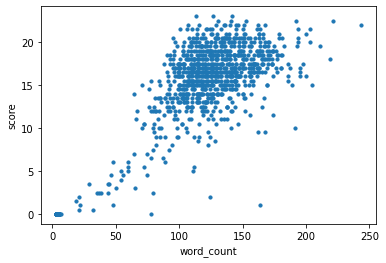

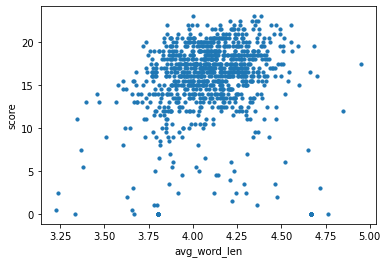

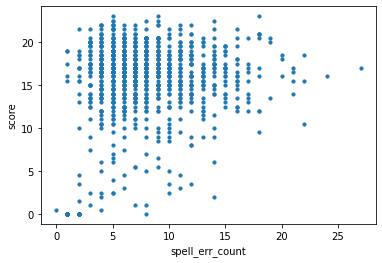

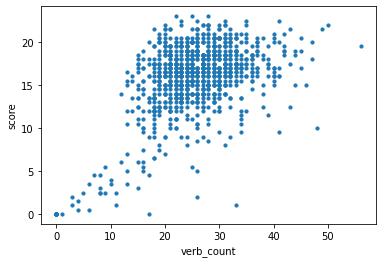

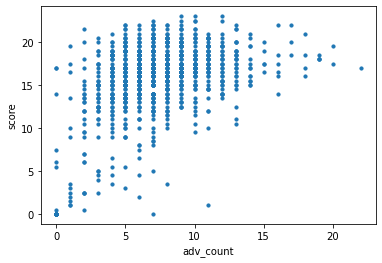

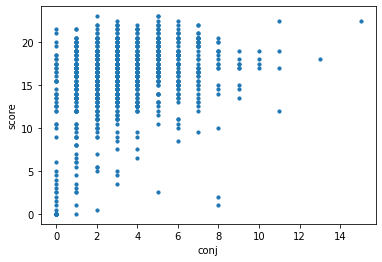

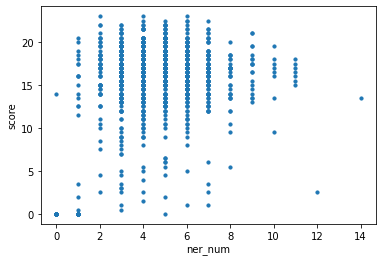

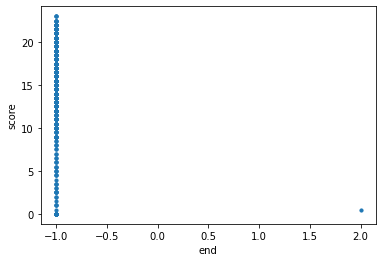

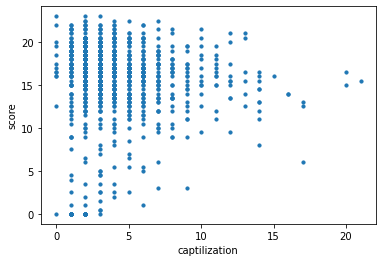

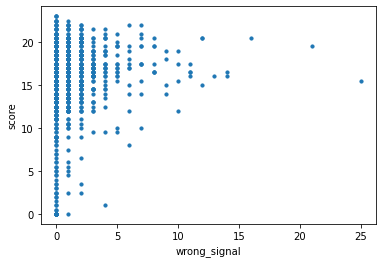

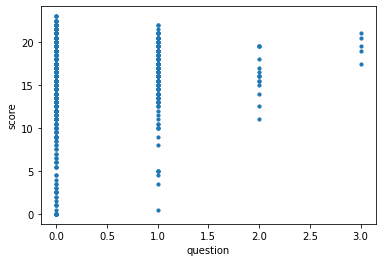

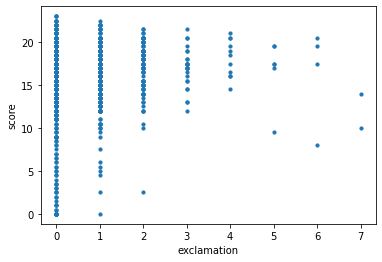

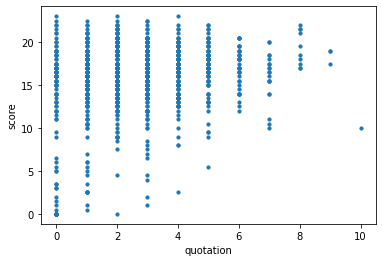

In [42]:
# 参数s表示散点的面积
features.plot.scatter(x = 'char_count', y = 'score', s=10)
features.plot.scatter(x = 'word_count', y = 'score', s=10)
features.plot.scatter(x = 'sent_count', y = 'score', s=10)
features.plot.scatter(x = 'avg_word_len', y = 'score', s=10)
features.plot.scatter(x = 'lemma_count', y = 'score', s=10)
features.plot.scatter(x = 'spell_err_count', y = 'score', s=10)
features.plot.scatter(x = 'noun_count', y = 'score', s=10)
features.plot.scatter(x = 'adj_count', y = 'score', s=10)
features.plot.scatter(x = 'verb_count', y = 'score', s=10)
features.plot.scatter(x = 'adv_count', y = 'score', s=10)
features.plot.scatter(x = 'conj', y = 'score', s=10)
features.plot.scatter(x = 'ps_conj', y = 'score', s=10)
features.plot.scatter(x = 'ner_num', y = 'score', s=10)
features.plot.scatter(x = 'end', y = 'score', s=10)
features.plot.scatter(x = 'captilization', y = 'score', s=10)
features.plot.scatter(x = 'wrong_signal', y = 'score', s=10)
features.plot.scatter(x = 'comma', y = 'score', s=10)
features.plot.scatter(x = 'question', y = 'score', s=10)
features.plot.scatter(x = 'exclamation', y = 'score', s=10)
features.plot.scatter(x = 'quotation', y = 'score', s=10)

In [43]:
n = len(features['char_count'] )
scores = features["score"]
char_count = features['char_count'].corr(scores,method="spearman")
word_count = features['word_count'].corr(scores,method="spearman")
sent_count = features['sent_count'].corr(scores,method="spearman")
avg_word_len = features['avg_word_len'].corr(scores,method="spearman")
lemma_count = features['lemma_count'].corr(scores,method="spearman")
spell_err_count = features['spell_err_count'].corr(scores,method="spearman")
noun_count =  features['noun_count'].corr(scores,method="spearman")
adj_count = features['adj_count'].corr(scores,method="spearman")
verb_count = features['verb_count'].corr(scores,method="spearman")
adv_count = features['adv_count'].corr(scores,method="spearman")
conj_count =  features["conj"].corr(scores,method="spearman")
ps_conj_count = features["ps_conj"].corr(scores,method="spearman")
ner_num = features['ner_num'].corr(scores,method='spearman')
end = features['end'].corr(scores,method='spearman')
captilization = features['captilization'].corr(scores,method='spearman')
wrong_signal = features['wrong_signal'].corr(scores,method='spearman')
comma = features['comma'].corr(scores,method='spearman')
question = features['question'].corr(scores,method='spearman')
exclamation = features['exclamation'].corr(scores,method='spearman')
quotation = features['quotation'].corr(scores,method='spearman')

In [45]:
# 封装成字典并按照value 排序
spearman_dic = {
    "char_count":char_count
    ,"word_count":word_count
    ,"sent_count":sent_count
    ,"avg_word_len":avg_word_len
    ,"lemma_count":lemma_count
    ,"spell_err_count":spell_err_count
    ,"noun_count":noun_count
    ,"adj_count":adj_count
    ,"verb_count":verb_count
    ,"adv_count":adv_count
    ,"conj_count":conj_count
    ,"ps_conj_count":ps_conj_count
    ,"ner_num":ner_num
    ,'end':end
    ,'captilization':captilization
    ,'wrong_signal':wrong_signal
    ,'comma':comma
    ,'exclamation':exclamation
    ,'quotation':quotation
    ,'question':question
}
a = sorted(spearman_dic.items(), key=lambda x: x[1], reverse=True)
for item in a:
    print(item)
# 排序可知,词汇丰富度/作文长度 对作文评分影响最重要，其次是形容词、名词、连词与动词的使用。

('lemma_count', 0.5900492618967987)
('char_count', 0.5610447020419941)
('word_count', 0.5131321348255092)
('adj_count', 0.4643060472605979)
('noun_count', 0.4531868654788258)
('ps_conj_count', 0.42338742019373443)
('adv_count', 0.42173414625123656)
('verb_count', 0.4101569091689511)
('conj_count', 0.35465992148936676)
('comma', 0.2664863575774475)
('sent_count', 0.26635519193646884)
('quotation', 0.2439939457312665)
('avg_word_len', 0.2290709317896946)
('wrong_signal', 0.19196122183933934)
('exclamation', 0.18424955976920795)
('ner_num', 0.1354307931658334)
('spell_err_count', 0.10274870757647674)
('question', 0.07628699241691425)
('end', -0.049579577623946706)
('captilization', -0.09303285162879481)


In [46]:
#删除相关度0.3以下的数据
irr_features = [feature for feature in spearman_dic if spearman_dic[feature]<0.3]
processed_features = features.drop(["essay","id"],axis=1)
processed_features = processed_features.drop(irr_features,axis=1)

In [47]:
# 保留所有变量
features = features.drop(["essay","id"],axis=1)

In [48]:
features.head()

score  word_count  ner_num  char_count  sent_count  avg_word_len  \
0   19.5         113        3         513          15      4.100840   
1   16.5         128        5         616          11      4.313869   
2   20.5         166        5         676          18      3.969512   
3   15.5         125        3         555          14      4.076923   
4   19.0         147        4         657          11      4.240000   

   lemma_count  spell_err_count  noun_count  adj_count  ...  adv_count  conj  \
0           88                5          27          7  ...          9     2   
1           88                6          28         11  ...          9     4   
2           93                4          30         15  ...         11     7   
3           79                7          26         10  ...         13     4   
4           89               15          32         10  ...         12     6   

   ps_conj  end  captilization  wrong_signal  comma  question  exclamation  \
0        8   -1              2             0      5         0            0   
1       14   -1              0             1      5         0            0   
2       15   -1              2             4      5         0            4   
3        8   -1              2             0      7         0            0   
4       13   -1              2             0      8         1            0   

   quotation  
0          6  
1          7  
2          1  
3          5  
4          3  

[5 rows x 21 columns]

In [49]:
processed_features.head()

score  word_count  char_count  lemma_count  noun_count  adj_count  \
0   19.5         113         513           88          27          7   
1   16.5         128         616           88          28         11   
2   20.5         166         676           93          30         15   
3   15.5         125         555           79          26         10   
4   19.0         147         657           89          32         10   

   verb_count  adv_count  conj  ps_conj  
0          26          9     2        8  
1          27          9     4       14  
2          33         11     7       15  
3          23         13     4        8  
4          28         12     6       13

In [50]:
# 计算特征与特征之间的皮尔森系数，画热力图
import seaborn as sns
plt.figure(figsize = (25,25))
corr_values = features.iloc[:,1:].corr() # pandas直接调用corr就能计算特征之间的相关系数
#遮住上半部分
mask = np.zeros_like(corr_values, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# 绘制热力图
sns.heatmap(corr_values, annot=True,vmax=1, square=True, cmap=sns.diverging_palette(20, 220, n=200),fmt='.2f',xticklabels=True, yticklabels=True)
plt.tight_layout()
# plt.savefig('prepare_data/columns37.png',dpi=600)
plt.show()

In [51]:
input_features = processed_features

## 数据标准化

In [52]:
from sklearn.preprocessing import StandardScaler
X = input_features.iloc[:,1:].values
y = input_features["score"].values
scaler = StandardScaler() #实例化
scaler.fit(X) #fit，本质是生成均值和方差
scaler.mean_ #查看均值的属性mean_
scaler.var_ #查看方差的属性var_

array([1.43391216e+03, 2.71804079e+04, 4.62845151e+02, 6.35621402e+01,
       1.96189525e+01, 7.47426380e+01, 1.29950948e+01, 4.89634042e+00,
       1.78926628e+01])

In [53]:
X_new = scaler.fit_transform(X) #使用fit_transform(data)一步达成结果
#scaler.inverse_transform(x_std) #使用inverse_transform逆转标准化

In [54]:
X_new

array([[-0.19770531, -0.08215492,  0.54338564, ...,  0.52210409,
        -0.54311994, -0.15752673],
       [ 0.19841762,  0.54259936,  0.54338564, ...,  0.52210409,
         0.36072555,  1.26092239],
       [ 1.20192905,  0.90653389,  0.77579421, ...,  1.07690897,
         1.71649377,  1.49733057],
       ...,
       [-3.04979043, -3.06641808, -3.31459668, ..., -1.97451785,
        -1.44696543, -2.04879223],
       [-3.04979043, -3.06641808, -3.31459668, ..., -1.97451785,
        -1.44696543, -2.04879223],
       [-3.04979043, -3.06641808, -3.31459668, ..., -1.97451785,
        -1.44696543, -2.04879223]])

## 构建新的特征矩阵

In [55]:
#X = np.concatenate((X_new, vectors), axis = 1)
X = np.concatenate((X_new, vectors_glove), axis = 1)
y = y

In [56]:
pd.DataFrame(X).head()

0         1         2         3         4         5         6    \
0 -0.197705 -0.082155  0.543386  0.147609 -0.645051  0.160388  0.522104   
1  0.198418  0.542599  0.543386  0.273039  0.258020  0.276056  0.522104   
2  1.201929  0.906534  0.775794  0.523898  1.161092  0.970069  1.076909   
3  0.119193  0.172599  0.125050  0.022179  0.032253 -0.186618  1.631714   
4  0.700173  0.791288  0.589867  0.774758  0.032253  0.391725  1.354311   

        7         8         9    ...       98        99        100       101  \
0 -0.543120 -0.157527 -0.140031  ... -0.310396 -0.048522 -0.090469  0.040780   
1  0.360726  1.260922 -0.112918  ... -0.277359 -0.055622 -0.121241 -0.014945   
2  1.716494  1.497331 -0.174340  ... -0.335874 -0.087150 -0.043894  0.039736   
3  0.360726 -0.157527 -0.105426  ... -0.290826 -0.114968 -0.088310  0.059998   
4  1.264571  1.024514 -0.166935  ... -0.275328 -0.048425 -0.055571 -0.031547   

        102       103       104       105       106       107  
0 -0.018749 -0.491331 -0.038897 -0.191221 -0.357166  0.401102  
1  0.010484 -0.449952 -0.120570 -0.120018 -0.292118  0.410741  
2  0.030225 -0.478335 -0.048218 -0.105493 -0.345961  0.393222  
3  0.015179 -0.484646 -0.057719 -0.102779 -0.333330  0.424934  
4 -0.016257 -0.460294 -0.074763 -0.195157 -0.378014  0.464494  

[5 rows x 108 columns]

In [57]:
# 检查是否有空值
pd.DataFrame(X).isnull().sum()

0      0
1      0
2      0
3      0
4      0
      ..
103    0
104    0
105    0
106    0
107    0
Length: 108, dtype: int64

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [83]:
linear_regressor = LinearRegression()
linear_regressor.fit(X_train, y_train)
y_pred = linear_regressor.predict(X_test)
for i in range(len(y_test)):
    print("预测分数：{}".format(y_pred[i]),"实际分数：{}".format(y_test[i]))
# The coefficients 表示每一个特征所占的权重
print("测试集得分：\n",linear_regressor.score(X_test,y_test))
print('LinearRegression Coefficients: \n', linear_regressor.coef_)
# The mean squared error
print("LinearRegression Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
# 平均绝对百分比误差（Mean Absolute Percentage Error）
#print('LinearRegression MAPE:%.2f' % np.average(np.abs((y_test-y_pred)/y_test)))
print("R2:%f"% r2_score(y_test, y_pred))
print('-' * 50)

预测分数：11.675340151604543 实际分数：16.0
预测分数：14.830418914845408 实际分数：18.5
预测分数：16.603328128013693 实际分数：17.0
预测分数：18.172896861949035 实际分数：18.5
预测分数：15.360513184042068 实际分数：15.0
预测分数：13.471822704323609 实际分数：14.0
预测分数：16.211949818672622 实际分数：16.5
预测分数：14.716861948722974 实际分数：19.0
预测分数：14.98868518323052 实际分数：18.5
预测分数：17.32730314919926 实际分数：18.0
预测分数：18.1737133304339 实际分数：21.5
预测分数：20.665371902305388 实际分数：19.0
预测分数：12.801917280280643 实际分数：10.0
预测分数：15.473914013476682 实际分数：19.0
预测分数：14.443225538807186 实际分数：9.0
预测分数：18.924627121388944 实际分数：15.0
预测分数：13.705868659111607 实际分数：18.0
预测分数：16.46625868926366 实际分数：19.0
预测分数：17.11563845294723 实际分数：18.5
预测分数：14.78036759356568 实际分数：16.0
预测分数：18.350220896491095 实际分数：16.0
预测分数：13.098942188454492 实际分数：7.5
预测分数：17.161257659098027 实际分数：19.5
预测分数：11.15750945021375 实际分数：13.0
预测分数：11.286200283324797 实际分数：13.5
预测分数：17.527318097734288 实际分数：17.0
预测分数：-0.3146889805174542 实际分数：0.0
预测分数：14.152548101575688 实际分数：11.0
预测分数：14.910602673961781 实际分数：16.0
预测分数：18.743788783550166 

In [74]:
from sklearn.metrics import classification_report
alpha = 200
ridge = Ridge(alpha=alpha)# 正则项的程度
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)
print("测试集得分：\n {0}".format(ridge.score(X_test,y_test)))
#print('Ridge Coefficients: \n', ridge.coef_)
print("Ridge Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
print("R2:%f"% r2_score(y_test, y_pred))
#print('Ridge MAPE:%.2f' % np.average(np.abs((y_test-y_pred)/y_test)))

print(classification_report(np.rint(y_pred), np.rint(y_test)))
print('-' * 50)

# 最佳：
'''
测试集得分：
 0.6781095758903712
Ridge Mean squared error: 7.86
R2:0.678110
'''

测试集得分：
 0.5762136830084303
Ridge Mean squared error: 9.13
R2:0.576214
Cohen's kappa score: 0.04
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       0.00      0.00      0.00         2
         2.0       0.00      0.00      0.00         7
         4.0       0.00      0.00      0.00         0
         5.0       0.00      0.00      0.00         0
         6.0       0.00      0.00      0.00         0
         7.0       0.00      0.00      0.00         0
         8.0       0.00      0.00      0.00         3
         9.0       0.00      0.00      0.00         2
        10.0       0.00      0.00      0.00         2
        11.0       0.00      0.00      0.00         5
        12.0       0.06      0.25      0.09         4
        13.0       0.12      0.09      0.11        11
        14.0       0.23      0.20      0.22        35
        15.0       0.41      0.14      0.21        64
        16.0       0.20      0.20      

'\n测试集得分：\n 0.6781095758903712\nRidge Mean squared error: 7.86\nR2:0.678110\n'

In [68]:
ridge_ = Ridge()
# 网格搜索  找到最佳的alpha值，也就是最佳的正则项系数
param_alpha = {'alpha': range(10,60,1)}
#传入模型和参数
grid = GridSearchCV(estimator=ridge_, param_grid=param_alpha) # 网格搜索同时满足了fit，search 和score 的三种功能
# 网格搜索会从参数中不断选取对应的参数进行组合，然后自动进行交叉验证，返回每一组参数下交叉验证的
grid.fit(X_train, y_train)
y_pred = grid.predict(X_test)
#输出最佳结果
print(grid.best_score_)
print(grid.best_estimator_)
print(grid.best_params_)

print("测试集最佳得分：\n",grid.best_score_)
print("Grid Ridge Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
#print('Grid Ridge MAPE:%.2f' % np.average(np.abs((y_test-y_pred)/y_test)))
print('-' * 50)

#-------------------绘制学习曲线------------------------#
'''
保留全部特征的：
最佳分数
0.7042819298865602
Ridge(alpha=10)
{'alpha': 10}
测试集最佳得分：
 0.7042819298865602
Grid Ridge Mean squared error: 7.07
'''

'''

不保留全部特征：
0.7138491691524768
Ridge(alpha=10)
{'alpha': 10}
测试集最佳得分：
 0.7138491691524768
Grid Ridge Mean squared error: 7.04

'''

0.7090871361744429
Ridge(alpha=10)
{'alpha': 10}
测试集最佳得分：
 0.7090871361744429
Grid Ridge Mean squared error: 8.01
Cohen's kappa score: 0.13
--------------------------------------------------


"\n\n不保留全部特征：\n0.7138491691524768\nRidge(alpha=10)\n{'alpha': 10}\n测试集最佳得分：\n 0.7138491691524768\nGrid Ridge Mean squared error: 7.04\n\n"

In [88]:
%%time
rf = ensemble.RandomForestRegressor()
params = {'n_estimators': range(50,70,1), 'max_depth':[10, 50, 100], 'max_features':[2, 5, 10]}
grid = GridSearchCV(estimator=rf, param_grid=params)
grid.fit(X_train, y_train)
y_pred = grid.predict(X_test)
print(grid.best_score_)
print(grid.best_estimator_)
print(grid.best_params_)

for i in range(len(y_test)):
    print("预测分数：{:.2f}".format(y_pred[i]),"实际分数：{}".format(y_test[i]))
    
print("测试集最佳得分：\n",grid.best_score_)
print("Grid RF Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
#print('Grid RF Variance score: %.2f' % ridge.score(X_test, y_test))
print('Grid RF MAPE:%.2f' % np.average(np.abs((y_test-y_pred)/y_test)))
print('Cohen\'s kappa score: %.2f' % cohen_kappa_score(np.rint(y_pred), np.rint(y_test)))
print('-' * 50)

'''
保留所有特征
0.7514017009641326
RandomForestRegressor(max_depth=100, max_features=10, n_estimators=54)
{'max_depth': 100, 'max_features': 10, 'n_estimators': 54}
'''

'''
不保留所有特征
0.7684131078350364
RandomForestRegressor(max_depth=50, max_features=10, n_estimators=59)
{'max_depth': 50, 'max_features': 10, 'n_estimators': 59}
测试集最佳得分：
 0.7684131078350364
Grid RF Mean squared error: 7.19
Grid RF MAPE:nan
'''

0.7527790086780808
RandomForestRegressor(max_depth=100, max_features=10, n_estimators=69)
{'max_depth': 100, 'max_features': 10, 'n_estimators': 69}
预测分数：14.71 实际分数：16.0
预测分数：17.20 实际分数：18.5
预测分数：17.24 实际分数：17.0
预测分数：17.81 实际分数：18.5
预测分数：15.28 实际分数：15.0
预测分数：17.59 实际分数：14.0
预测分数：14.61 实际分数：16.5
预测分数：16.73 实际分数：19.0
预测分数：17.14 实际分数：18.5
预测分数：16.93 实际分数：18.0
预测分数：17.39 实际分数：21.5
预测分数：17.99 实际分数：19.0
预测分数：10.75 实际分数：10.0
预测分数：15.33 实际分数：19.0
预测分数：11.93 实际分数：9.0
预测分数：17.42 实际分数：15.0
预测分数：15.20 实际分数：18.0
预测分数：17.57 实际分数：19.0
预测分数：17.59 实际分数：18.5
预测分数：14.15 实际分数：16.0
预测分数：16.55 实际分数：16.0
预测分数：15.41 实际分数：7.5
预测分数：14.85 实际分数：19.5
预测分数：13.94 实际分数：13.0
预测分数：15.07 实际分数：13.5
预测分数：16.90 实际分数：17.0
预测分数：0.00 实际分数：0.0
预测分数：15.91 实际分数：11.0
预测分数：14.49 实际分数：16.0
预测分数：18.25 实际分数：20.0
预测分数：17.06 实际分数：14.5
预测分数：18.27 实际分数：20.0
预测分数：17.17 实际分数：18.0
预测分数：17.12 实际分数：15.5
预测分数：17.47 实际分数：18.5
预测分数：16.14 实际分数：19.5
预测分数：14.23 实际分数：16.0
预测分数：17.80 实际分数：17.5
预测分数：17.42 实际分数：18.0
预测分数：16.96 实际分数：17.5
预测分数：16.53 实际分数

"\n不保留所有特征\n0.7684131078350364\nRandomForestRegressor(max_depth=50, max_features=10, n_estimators=59)\n{'max_depth': 50, 'max_features': 10, 'n_estimators': 59}\n测试集最佳得分：\n 0.7684131078350364\nGrid RF Mean squared error: 7.19\nGrid RF MAPE:nan\n"

In [75]:
%%time
model = xgb.XGBRegressor()
params = {'n_estimators': [100, 150, 160], 'learning_rate': [0.1, 0.5, 1.0]}
grid = GridSearchCV(estimator=model, param_grid=params)
grid.fit(X_train, y_train)
y_pred = grid.predict(X_test)
print("测试集最佳得分：\n",grid.best_score_)
print("Grid xgboost Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
print('Grid xgboost MAPE:%.2f' % np.average(np.abs((y_test-y_pred)/y_test)))
print('Cohen\'s kappa score: %.2f' % cohen_kappa_score(np.rint(y_pred), np.rint(y_test)))
print('-' * 50)

'''
0.7452695332350947
Grid xgboost Mean squared error: 6.66
Grid xgboost MAPE:inf
-----------------------
'''

'''
测试集最佳得分：
 0.7555525239403682
Grid xgboost Mean squared error: 7.32
Grid xgboost MAPE:inf

'''

测试集最佳得分：
 0.7273833687271393
Grid xgboost Mean squared error: 6.37
Grid xgboost MAPE:inf
Cohen's kappa score: 0.07
--------------------------------------------------
Wall time: 46.7 s


'\n测试集最佳得分：\n 0.7555525239403682\nGrid xgboost Mean squared error: 7.32\nGrid xgboost MAPE:inf\n\n'